In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stocks/GOOGL.csv
/kaggle/input/stocks/ABBV.csv
/kaggle/input/stocks/TSLA.csv
/kaggle/input/stocks/MSFT.csv
/kaggle/input/stocks/PLD.csv
/kaggle/input/stocks/BA.csv
/kaggle/input/stocks/AAPL.csv
/kaggle/input/stocks/XOM.csv
/kaggle/input/stocks/BLK.csv
/kaggle/input/stocks/PFE.csv
/kaggle/input/stocks/COP.csv
/kaggle/input/stocks/MRK.csv
/kaggle/input/stocks/NVDA.csv
/kaggle/input/stocks/SBUX.csv
/kaggle/input/stocks/AMZN.csv
/kaggle/input/stocks/ADBE.csv
/kaggle/input/stocks/BAC.csv
/kaggle/input/stocks/LIN.csv
/kaggle/input/stocks/JNJ.csv
/kaggle/input/stocks/AMD.csv
/kaggle/input/stocks/CRM.csv
/kaggle/input/stocks/FCX.csv
/kaggle/input/stocks/HON.csv
/kaggle/input/stocks/CVX.csv
/kaggle/input/stocks/CAT.csv
/kaggle/input/stocks/JPM.csv
/kaggle/input/stocks/NEE.csv
/kaggle/input/stocks/META.csv
/kaggle/input/stocks/GS.csv
/kaggle/input/stocks/DUK.csv
/kaggle/input/stocks/SPY.csv
/kaggle/input/stocks/HD.csv
/kaggle/input/stocks/AMT.csv


In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import warnings
import torch
from tqdm import tqdm
import seaborn as sns
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [35]:
# 📌 Quantitative Insights – Rolling Monte Carlo VaR & CVaR

# 1. Rolling Monte Carlo Simulation:
#    - Simulates 30-day future portfolio returns using a rolling historical window (e.g., 252 days).
#    - Dynamically updates the mean (μ) and covariance matrix (Σ) from historical log returns.
#    - Allows daily tracking of how forward-looking portfolio risk evolves over time.

# 2. Value at Risk (VaR):
#    - Estimates the maximum expected loss under normal market conditions at a 95% confidence level.
#    - Useful for setting capital buffers and defining risk thresholds.

# 3. Conditional VaR (CVaR):
#    - Measures the **average loss beyond the 95% VaR threshold**, i.e., in the worst-case tail scenarios.
#    - Captures extreme downside better than VaR alone.

# 4. Dynamic Risk Monitoring:
#    - Produces a time series of VaR/CVaR metrics to spot **periods of rising systemic risk**.
#    - Enables preemptive action like rebalancing, hedging, or de-risking.

# 5. Visual Risk Analysis:
#    - Time series plots highlight risk escalation visually.
#    - Heatmaps can flag clusters of elevated risk across time.

In [3]:
data_dir = "/kaggle/input/stocks/"
close_data = {}

In [4]:
for file in os.listdir(data_dir):
    if file.endswith(".csv") and file.upper() != "SPY.CSV":
        ticker = file.replace(".csv", "")
        path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(path, usecols=["Date", "Close"])
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df.set_index("Date", inplace=True)
            df = df[["Close"]].rename(columns={"Close": ticker})
            close_data[ticker] = df
        except Exception as e:
            print(f"⚠️ Skipped {ticker}: {e}")

In [5]:
price_df = pd.concat(close_data.values(), axis=1)
price_df.dropna(inplace=True)
price_df.head()


,GOOGL,ABBV,TSLA,MSFT,PLD,BA,AAPL,XOM,BLK,PFE,...,HON,CVX,CAT,JPM,NEE,META,GS,DUK,HD,AMT
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-16,56.449364,69.546310,18.439333,103.964432,54.155453,356.182556,52.803131,59.657154,346.788879,31.670357,...,135.154526,88.555916,123.973625,90.689362,36.640392,158.175766,190.480820,62.046329,166.063080,124.874329
2018-10-17,56.175861,69.818710,18.118668,103.692802,53.307426,353.522705,52.574932,59.877586,350.061249,32.131763,...,133.875504,88.390137,121.929092,91.699608,36.539856,158.813339,196.134232,61.915993,158.848541,125.722824
2018-10-18,54.697220,68.025391,17.594000,101.622894,53.485516,347.574219,51.346077,60.134720,339.878540,31.720819,...,131.452927,88.525780,117.149933,90.246864,36.700291,154.330460,193.273087,62.291630,154.790924,125.817162
2018-10-19,55.059406,66.564995,17.333332,101.772751,53.926498,344.585480,52.128086,60.222897,341.391510,32.081291,...,129.996033,89.030685,114.007195,90.096550,37.104576,153.463791,195.000092,63.433830,154.284790,128.697083
2018-10-22,55.367786,63.765282,17.396667,102.681252,53.646629,344.314667,52.446590,59.620434,333.495239,31.987566,...,129.267578,88.329834,111.741287,88.802422,36.933445,154.190979,190.394882,63.349491,153.341141,127.925713


In [6]:
log_returns = np.log(price_df / price_df.shift(1)).dropna()
tickers = log_returns.columns.tolist()

mu = log_returns.mean().values
cov = LedoitWolf().fit(log_returns).covariance_
S0 = price_df.loc[log_returns.index[-1], tickers].values
weights = np.ones(len(tickers)) / len(tickers)
weights_torch = torch.tensor(weights, dtype=torch.float32, device=device)

In [7]:
window_size = 252
n_days_forward = 30
n_sim = 1000

var_series, cvar_series, dates = [], [], []

In [8]:
for i in tqdm(range(window_size, len(log_returns) - n_days_forward), desc="Rolling VaR Simulation"):
    window_data = log_returns.iloc[i - window_size:i]
    mu_win = window_data.mean().values
    cov_win = LedoitWolf().fit(window_data).covariance_
    S0_win = price_df.iloc[i].values

    mu_t = torch.tensor(mu_win, dtype=torch.float32, device=device)
    cov_t = torch.tensor(cov_win, dtype=torch.float32, device=device)
    S0_t = torch.tensor(S0_win, dtype=torch.float32, device=device)

    dist = torch.distributions.MultivariateNormal(mu_t, covariance_matrix=cov_t)
    
    final_vals = []
    for _ in range(n_sim):
        prices = S0_t.clone()
        for _ in range(n_days_forward):
            shock = dist.sample()
            prices *= torch.exp(shock)
        final_vals.append(torch.dot(prices, weights_torch).item())

    final_vals = np.array(final_vals)
    var_95 = np.percentile(final_vals, 5)
    cvar_95 = final_vals[final_vals <= var_95].mean()

    var_series.append(var_95)
    cvar_series.append(cvar_95)
    dates.append(price_df.index[i])

Rolling VaR Simulation: 100%|██████████| 1317/1317 [52:20<00:00,  2.38s/it]


In [9]:
var_df = pd.DataFrame({'Date': dates, 'VaR_95': var_series, 'CVaR_95': cvar_series}).set_index("Date")

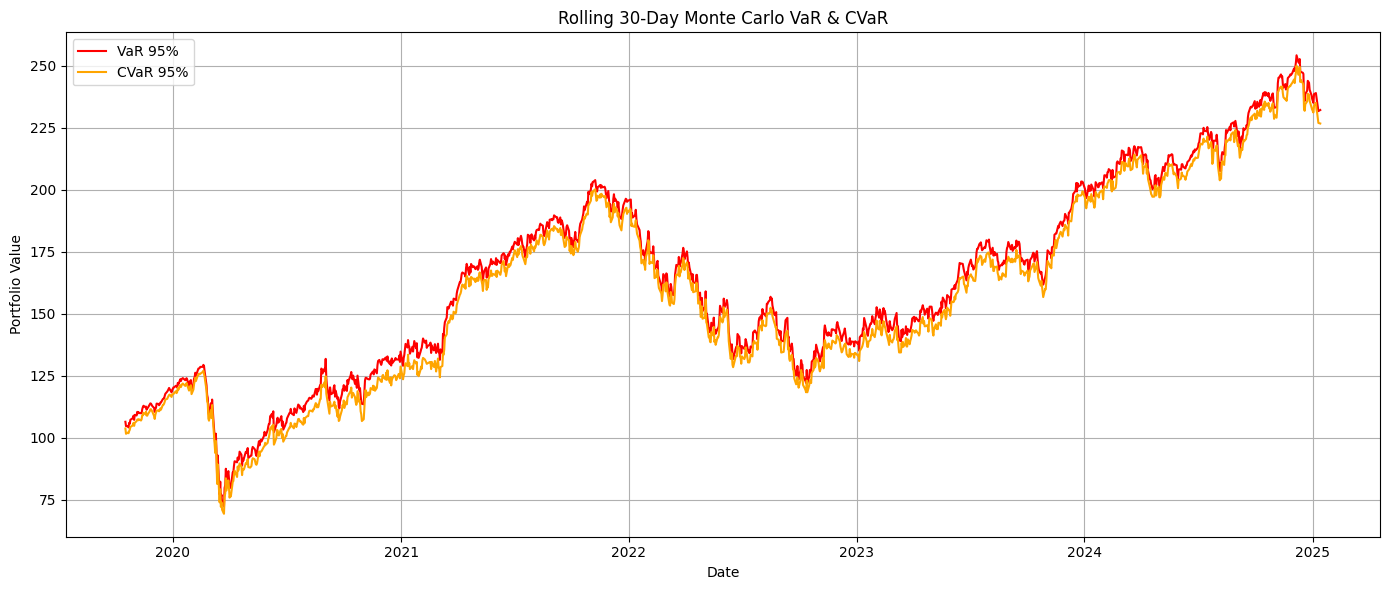

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(var_df.index, var_df['VaR_95'], label="VaR 95%", color="red")
plt.plot(var_df.index, var_df['CVaR_95'], label="CVaR 95%", color="orange")
plt.title("Rolling 30-Day Monte Carlo VaR & CVaR")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

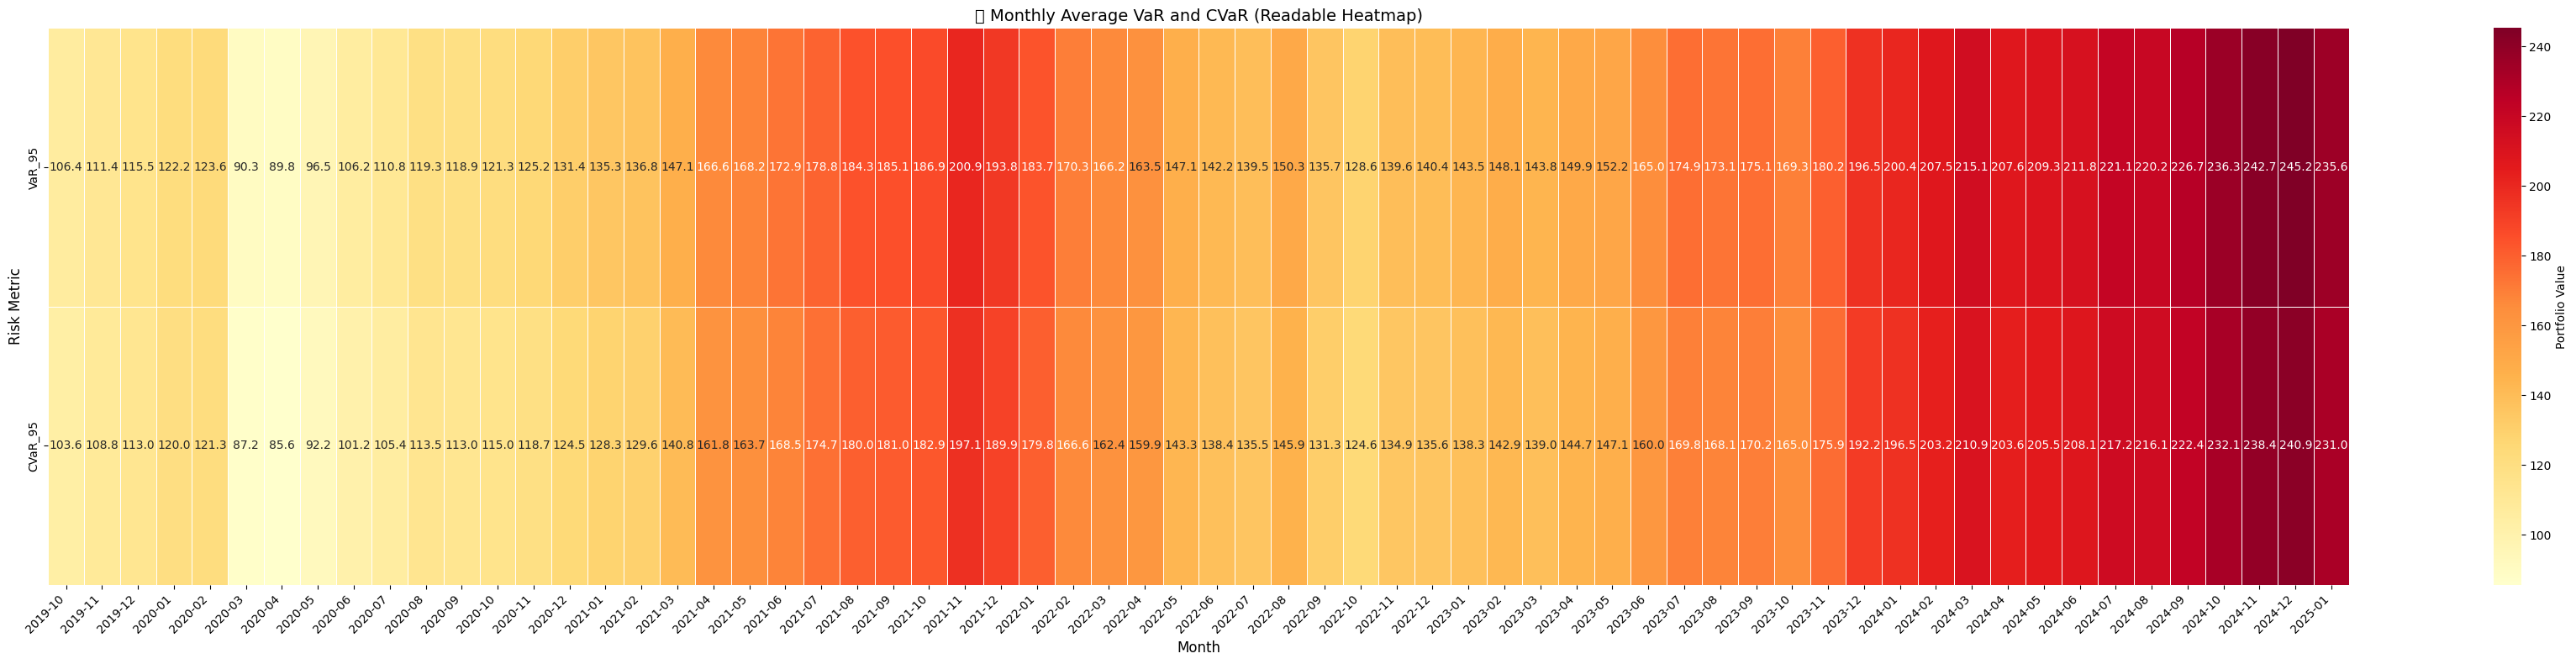

In [25]:
# Resample to monthly means for readability
monthly_risk = var_df.resample('M').mean()
monthly_risk.index = monthly_risk.index.strftime('%Y-%m')  # Format as "YYYY-MM"

plt.figure(figsize=(35, 8))
sns.heatmap(
    monthly_risk.T, 
    cmap="YlOrRd", 
    annot=True, 
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Portfolio Value'}
)

plt.title("🧯 Monthly Average VaR and CVaR (Readable Heatmap)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Risk Metric", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

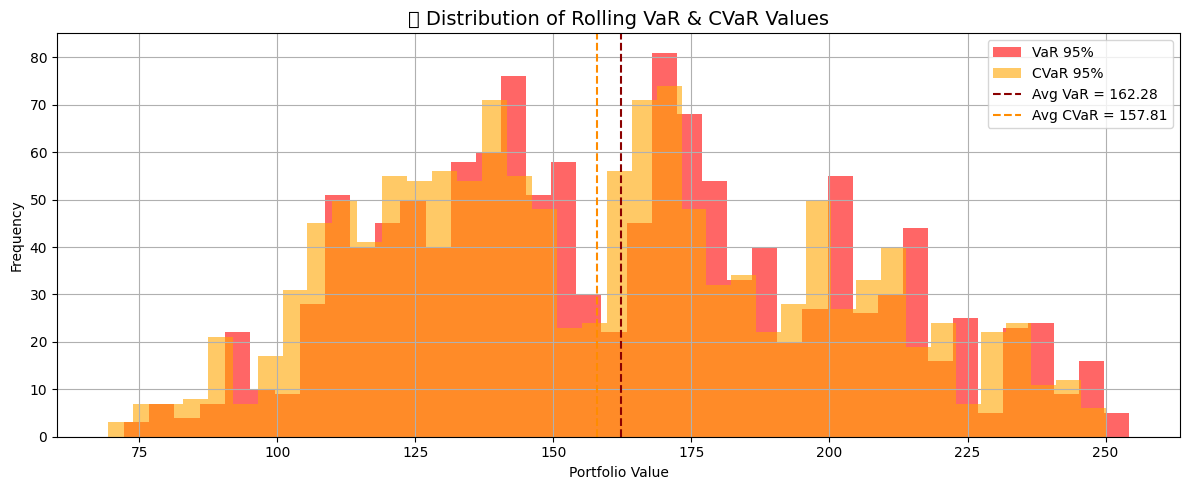

In [31]:
plt.figure(figsize=(12, 5))
plt.hist(var_df['VaR_95'], bins=40, alpha=0.6, label="VaR 95%", color='red')
plt.hist(var_df['CVaR_95'], bins=40, alpha=0.6, label="CVaR 95%", color='orange')
plt.axvline(var_df['VaR_95'].mean(), color='darkred', linestyle='--', label=f"Avg VaR = {var_df['VaR_95'].mean():.2f}")
plt.axvline(var_df['CVaR_95'].mean(), color='darkorange', linestyle='--', label=f"Avg CVaR = {var_df['CVaR_95'].mean():.2f}")
plt.title("📊 Distribution of Rolling VaR & CVaR Values", fontsize=14)
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


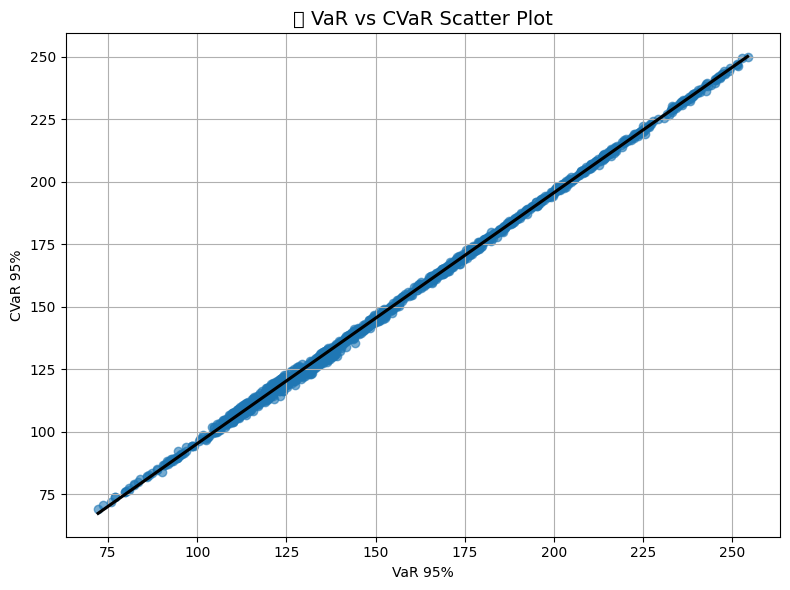

In [32]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(
    x=var_df["VaR_95"], 
    y=var_df["CVaR_95"], 
    scatter_kws={'alpha':0.6}, 
    line_kws={"color": "black"}
)
plt.title("📈 VaR vs CVaR Scatter Plot", fontsize=14)
plt.xlabel("VaR 95%")
plt.ylabel("CVaR 95%")
plt.grid(True)
plt.tight_layout()
plt.show()


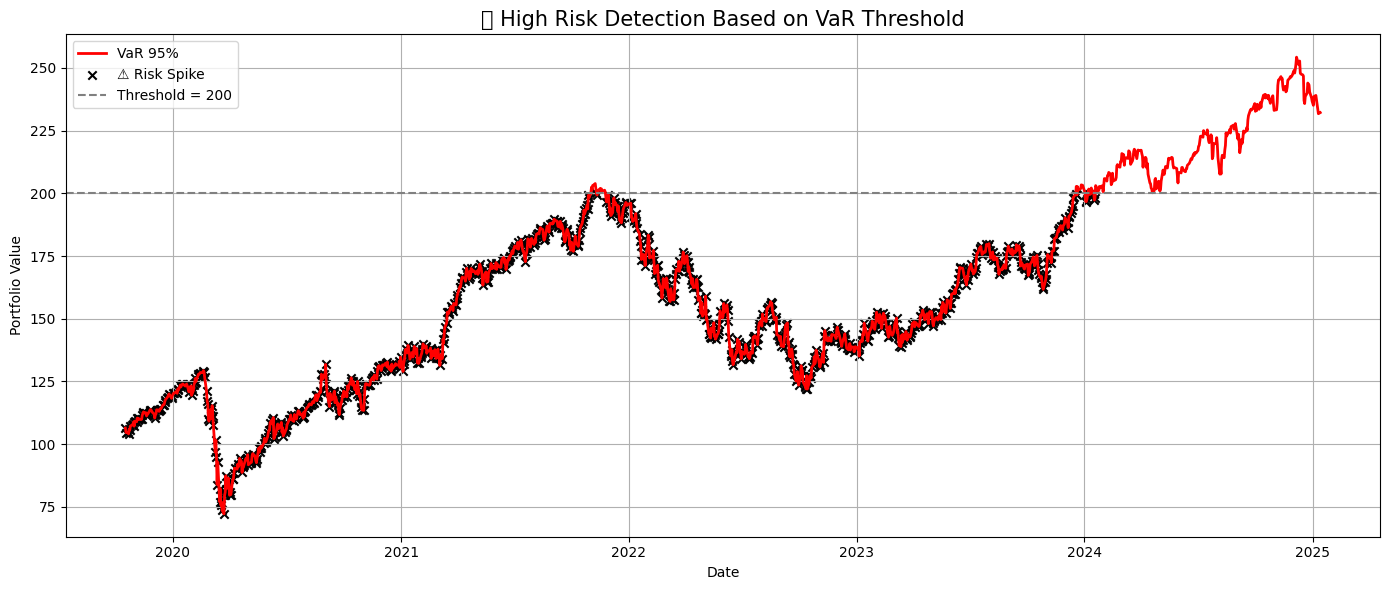

In [34]:
threshold = 200
high_risk_periods = var_df[var_df['VaR_95'] < threshold]

plt.figure(figsize=(14, 6))
plt.plot(var_df.index, var_df['VaR_95'], label="VaR 95%", color="red", linewidth=2)
plt.scatter(high_risk_periods.index, high_risk_periods['VaR_95'], color="black", marker="x", label="⚠️ Risk Spike")
plt.axhline(threshold, color="gray", linestyle="--", label=f"Threshold = {threshold}")

plt.title("🚨 High Risk Detection Based on VaR Threshold", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
